# V. Investmet Strategy

Date: 28/01/2020

In this notebook an investment strategy is developed using the signals from the ML model, and backtested.

In [1]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import *
import matplotlib.pyplot as plt

import statsmodels.api as sm
import quandl

%matplotlib inline

## 0. Loading the data

We load the output of the ML model, the risk free data and the CRSP msf data.

### 0.1. Investment signals

In [2]:
signals = pd.read_csv('output/signals.csv',
                      parse_dates = ['ANNDT_ACT','FPEDATS'])

In [3]:
# Keep only vars needed:
signals = signals[['TICKER','FPEDATS','FEC_pred','FEC']]
signals.columns = ['TICKER','FPEDATS','signal','signal_true']

# Create year and month fields:
signals['PYEAR'] = signals.FPEDATS.dt.year
signals['PMON'] = signals.FPEDATS.dt.month

In [4]:
print('Shape of the dataset: %s' % str(signals.shape))
print('Interval of time covered: %s to %s' % (min(signals.FPEDATS),max(signals.FPEDATS)))
print('Number of Companies covered: %s' % signals.TICKER.nunique())

Shape of the dataset: (459, 6)
Interval of time covered: 2015-01-31 00:00:00 to 2018-12-31 00:00:00
Number of Companies covered: 33


### 0.2. Load the CRSP monthly stock data

Here I am going to load the CRSP monthly stock data:

In [5]:
msf = pd.read_csv('output/msf_prep.csv', parse_dates=['date'])

In [6]:
msf = msf.loc[msf.date >= '2015-01-31']

In [7]:
print('Shape of the dataset: %s' % str(msf.shape))
print('Interval of time covered: %s to %s' % (min(msf.date),max(msf.date)))
print('Number of Companies covered: %s' % msf.TICKER.nunique())

Shape of the dataset: (1550, 9)
Interval of time covered: 2015-01-31 00:00:00 to 2018-12-31 00:00:00
Number of Companies covered: 35


## 1. Implementing the Investment Startegy

Here, the predicted surprises are used as investment signals and the depicted investment strategy is implmented.

In [8]:
# Select companies only reporting in FP as mentioned:
mon = [3,6,9,12]
signals = signals.loc[signals.PMON.isin(mon)]

print('The sample has been reduced to: %s companies' % signals.TICKER.nunique())

The sample has been reduced to: 28 companies


### 2.1. Create portfolios based on predicted surprises

For every quarter 3 portfolios are formed based on: positive surprise, no surprise or negative surprise.

In [9]:
dec = signals[['TICKER','PYEAR','PMON','signal','signal_true']].groupby(['PYEAR','PMON','TICKER'], as_index=False).mean().sort_values(['PYEAR','PMON'])

# Format the date to be last day of month of Fiscal Period:
dec[['PYEAR','PMON']] = dec[['PYEAR','PMON']].astype('str')
dec['FPdate'] = np.where(dec.PMON == '12', dec.PYEAR + dec.PMON, dec.PYEAR +'0'+ dec.PMON)
dec['FPdate'] = pd.to_datetime(dec['FPdate'], format="%Y%m") + MonthEnd(1)

Set the holding periods:

In [10]:
#  Holding Period Length: K in months
K = 3

# Set holding period from start next month, K months:
dec['hdate1']=dec['FPdate']+MonthBegin(1)
dec['hdate2']=dec['hdate1']+MonthEnd(K) # End of holding period

And merge the surprise portfolio data with the monthly returns:

In [11]:
tmp_ret = msf[['TICKER','date','ret','sprtrn']]

# Merge both:
port = tmp_ret.merge(dec, on=['TICKER'], how='inner')

# Keep only rows of month data that are in holding period:
port = port[(port['hdate1']<=port['date']) & (port['date']<=port['hdate2'])]
port = port.sort_values(by=['date','signal','FPdate','TICKER']).drop_duplicates()

# Now average the monthly return over all securities in each portfolio:
dec2 = port.groupby(['date','signal','FPdate'])['ret','sprtrn'].mean().reset_index()

Compute each portfolio abnormal returns:

In [12]:
# Make regressions for each portfolio:

def estimate_alpha_beta(data):
    Y = data['ret']
    X = data['sprtrn']
    X = sm.add_constant(X)
    
    result = sm.OLS(Y, X).fit()
    
    return result.params

# Estimate alpha&beta:
alpha_beta = dec2.groupby('signal').apply(estimate_alpha_beta)
alpha_beta.columns = ['alpha','beta']

# Merge back:
dec2 = dec2.merge(alpha_beta, on='signal', how='left')

# Compute abnormal returns:
dec2['abret'] = dec2.ret - (dec2.alpha + dec2.beta*dec2.sprtrn)

# Drop ret and sprtrn:
dec2.drop(['sprtrn','alpha','beta'], axis=1, inplace=True)

Create one return series per surprise portfolio:

In [13]:
ewret = dec2.groupby(['date','signal'])['abret'].mean().reset_index()
ewstd = dec2.groupby(['date','signal'])['abret'].std().reset_index()
ewret = ewret.rename(columns={'abret':'ewret'})
ewstd = ewstd.rename(columns={'abret':'ewretstd'})
ewretdat = pd.merge(ewret, ewstd, on=['date','signal'], how='inner')
ewretdat = ewretdat.sort_values(by=['signal'])

In [14]:
# Pivot and format:
ewretdat2 = ewretdat.pivot_table(index=['date'], columns='signal', values='ewret')
ewretdat2 = ewretdat2.add_prefix('port')

### 2.2. Compute Long-Short portfolio returns

Now here we create a long-short portfolio:

In [15]:
# Fill NAs with zero:
ewretdat2.fillna(value=0,axis=1, inplace=True)

In [16]:
# Create the long_short portfolio:
ewretdat2['long_short'] = ewretdat2['port3'] - ewretdat2['port1']

In [17]:
# Compute the Cumulative returns:
ewretdat2['1+port1']=1+ewretdat2['port1']
ewretdat2['1+port3']=1+ewretdat2['port3']
ewretdat2['1+ls'] = 1+ewretdat2['long_short']

ewretdat2['car_port3']=ewretdat2['1+port3'].cumprod()-1
ewretdat2['car_port1']=ewretdat2['1+port1'].cumprod()-1
ewretdat2['car_long_short']=ewretdat2['1+ls'].cumprod()-1

### 2.3. Plot the different portfolios

First, plot the investment signals:

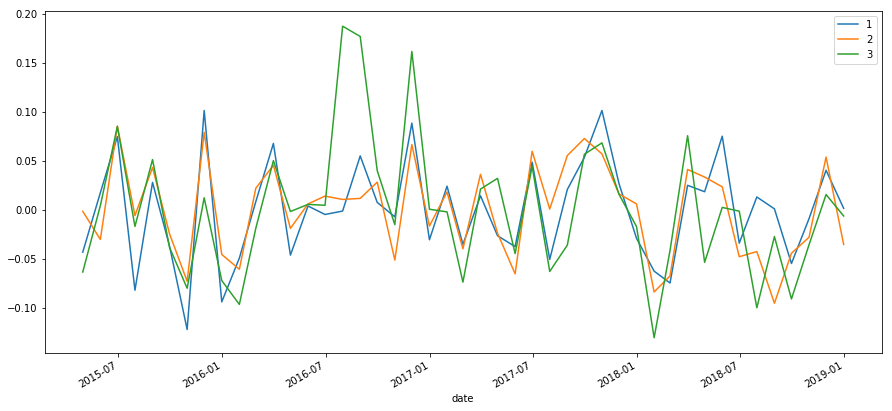

In [18]:
ewretdat.set_index('date').groupby('signal')['ewret'].plot(legend=True, figsize=(15,7));

And the cumulative abnormal returns:

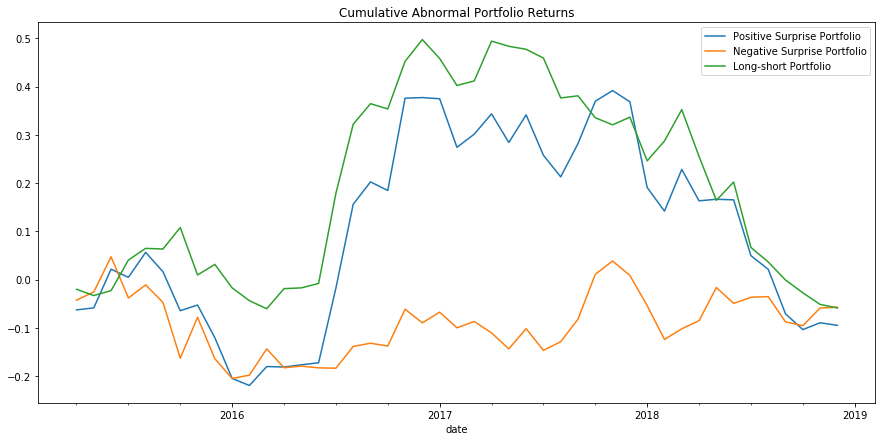

In [19]:
# Rename:
ewretdat3 = ewretdat2[['car_port3','car_port1','car_long_short']]
ewretdat3.columns = ['Positive Surprise Portfolio','Negative Surprise Portfolio','Long-short Portfolio']

fig = ewretdat3.plot(figsize=(15,7))
fig.set_title('Cumulative Abnormal Portfolio Returns')
plt.show()

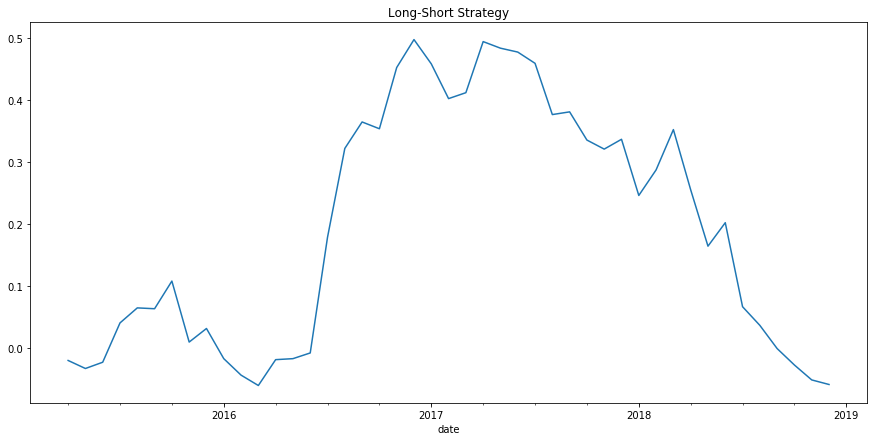

In [20]:
fig2 = ewretdat3['Long-short Portfolio'].plot(figsize=(15,7))
fig2.set_title('Long-Short Strategy')
plt.show()